In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ptfrwrd","key":"4a2f5a982ed53062345976efa42bd4c8"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# ! kaggle competitions list 

! kaggle competitions download -c lish-moa


  0% 0.00/38.9k [00:00<?, ?B/s]
100% 38.9k/38.9k [00:00<00:00, 15.1MB/s]
  0% 0.00/257k [00:00<?, ?B/s]
100% 257k/257k [00:00<00:00, 80.6MB/s]
 60% 33.0M/54.8M [00:00<00:01, 15.7MB/s]
100% 54.8M/54.8M [00:00<00:00, 66.4MB/s]
  0% 0.00/233k [00:00<?, ?B/s]
100% 233k/233k [00:00<00:00, 77.2MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 150MB/s]


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.simplefilter(action='ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
# use this code to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Explore data:

In [11]:
# read all files
# we need only features sets and train targets scored set

train_targets_nonscored = pd.read_csv('train_targets_nonscored.csv.zip')
test_features = pd.read_csv('test_features.csv.zip')
train_features = pd.read_csv('train_features.csv.zip')
train_targets_scored = pd.read_csv('train_targets_scored.csv.zip')
sample_submission = pd.read_csv('sample_submission.csv.zip')

In [12]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-67

In [13]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhib

In [14]:
test_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-67

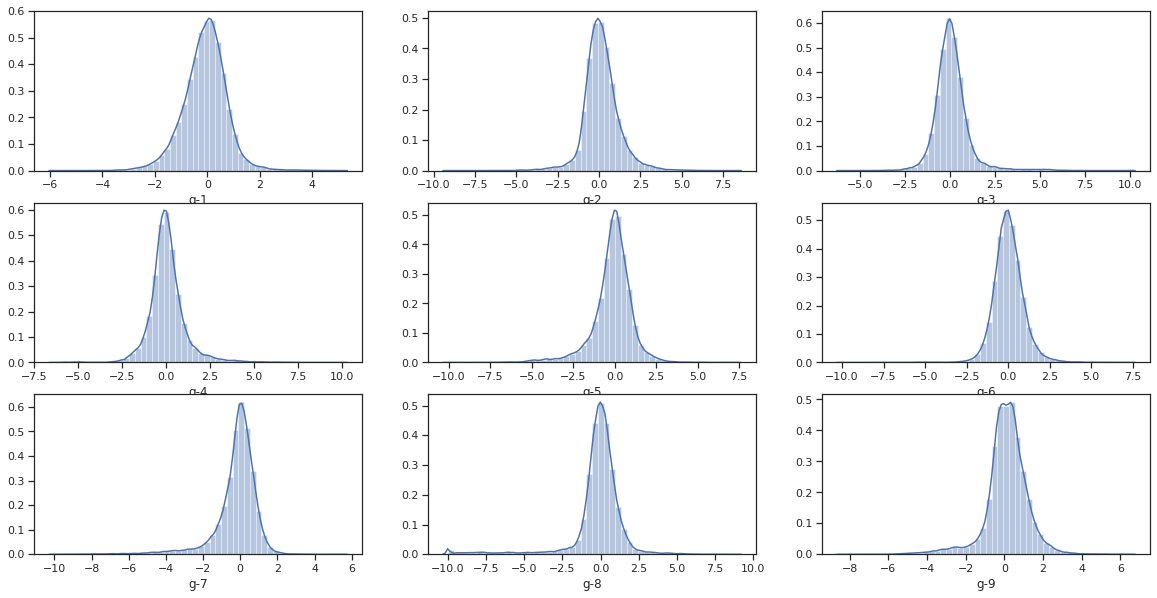

In [47]:
sns.set(style="ticks")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
for i, column in enumerate(train_features.columns[5:14]):
    sns.distplot(train_features[column],ax=axes[i//3,i%3])

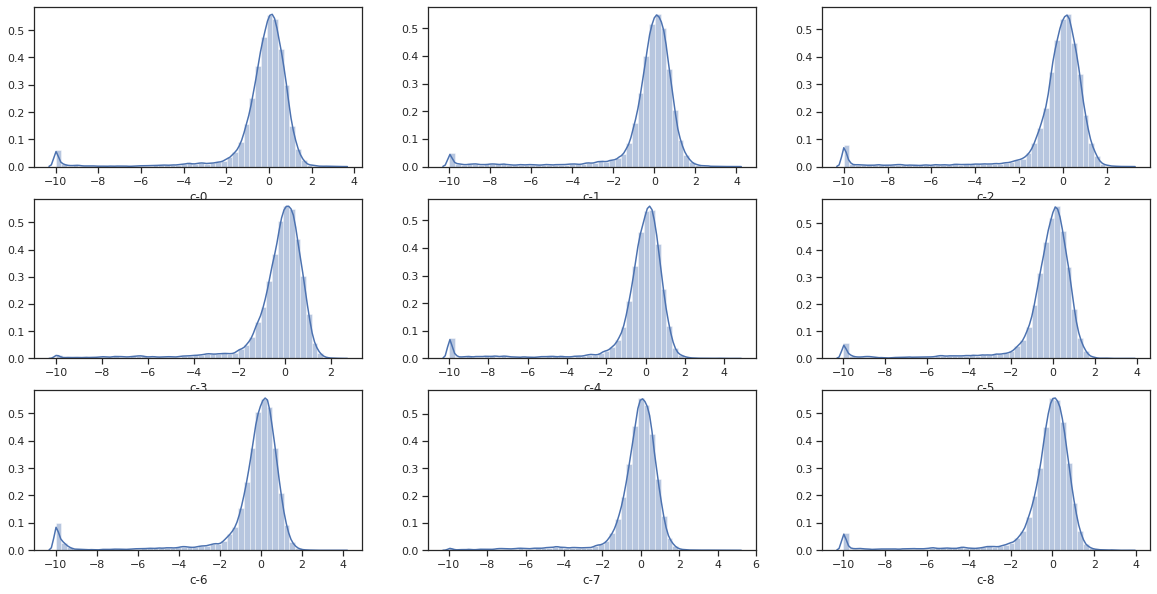

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
for i, column in enumerate(train_features.columns[776:785]):
    sns.distplot(train_features[column],ax=axes[i//3,i%3])

In [58]:
train_columns = train_features.columns.to_list()
g_list = [i for i in train_columns if i.startswith('g-')]
c_list = [i for i in train_columns if i.startswith('c-')]
print('g-size: ', len(g_list))
print('c-size: ', len(c_list))

g-size:  772
c-size:  100


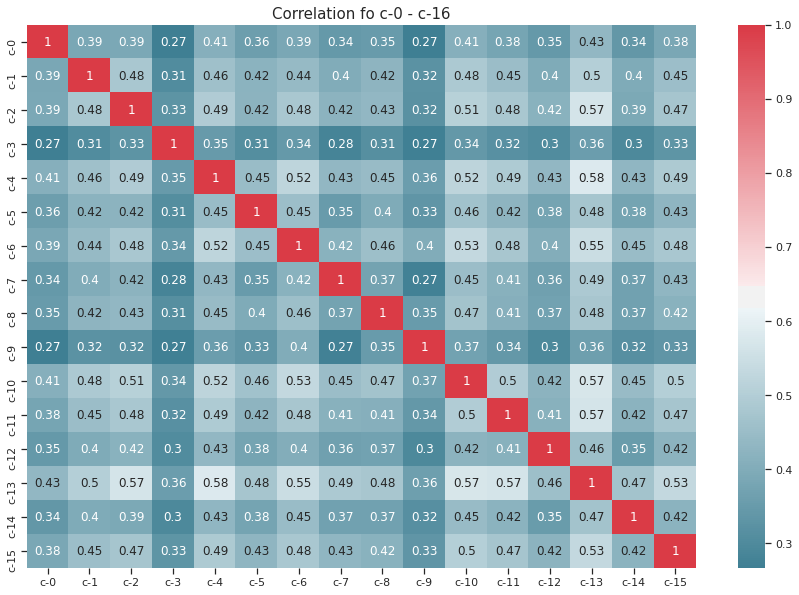

In [76]:
cells = train_features[c_list[:16]]


plt.figure(figsize=(15,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cells.corr(method='spearman'), cmap=cmap, annot=True)
plt.title('Correlation fo c-0 - c-16', fontsize=15)
plt.show()

In [69]:
cells = train_features[c_list]
correlations = cells.corr(method='spearman').abs().unstack().sort_values(kind="quicksort",ascending=False).reset_index()

correlations = correlations[correlations['level_0'] != correlations['level_1']] #preventing 1.0 corr
corr_max=correlations.level_0.head(150).tolist()
corr_max=list(set(corr_max)) #removing duplicates

corr_min=correlations.level_0.tail(50).tolist()
corr_min=list(set(corr_min)) #removing duplicates

In [70]:
correlations.head()

,level_0,level_1,0
100,c-73,c-13,0.684758
101,c-13,c-73,0.684758
102,c-13,c-94,0.636929
103,c-94,c-13,0.636929
104,c-13,c-26,0.604197


In [71]:
correlations.tail()

,level_0,level_1,0
9995,c-3,c-16,0.217195
9996,c-58,c-74,0.203461
9997,c-74,c-58,0.203461
9998,c-9,c-16,0.188897
9999,c-16,c-9,0.188897


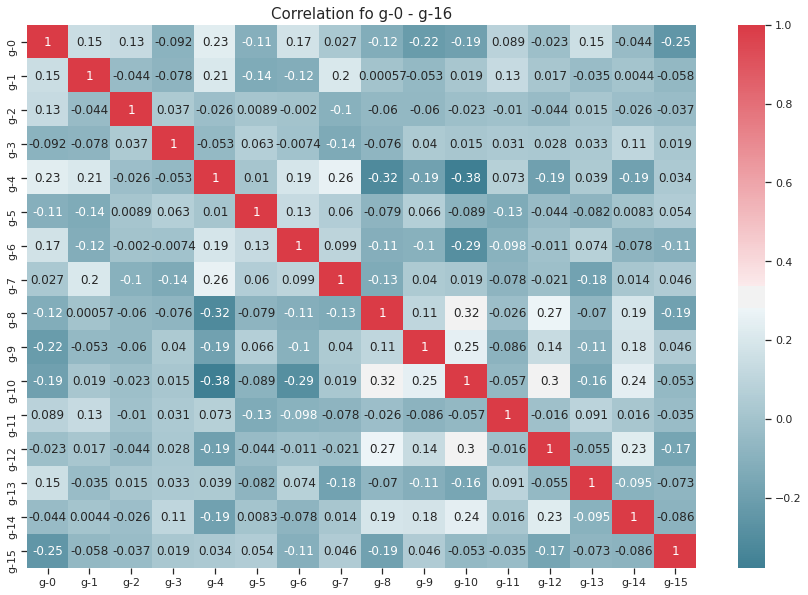

In [75]:
geans = train_features[g_list[:16]]


plt.figure(figsize=(15,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(geans.corr(method='spearman'), cmap=cmap, annot=True)
plt.title('Correlation fo g-0 - g-16', fontsize=15)
plt.show()

In [78]:
geans = train_features[g_list]
correlations = geans.corr(method='spearman').abs().unstack().sort_values(kind="quicksort",ascending=False).reset_index()

correlations = correlations[correlations['level_0'] != correlations['level_1']] #preventing 1.0 corr
corr_max=correlations.level_0.head(150).tolist()
corr_max=list(set(corr_max)) #removing duplicates

corr_min=correlations.level_0.tail(50).tolist()
corr_min=list(set(corr_min)) #removing duplicates

In [79]:
correlations.head()

,level_0,level_1,0
772,g-253,g-696,0.686565
773,g-696,g-253,0.686565
774,g-369,g-410,0.676415
775,g-410,g-369,0.676415
776,g-441,g-696,0.644685


In [80]:
correlations.tail()

,level_0,level_1,0
595979,g-165,g-56,0.000003
595980,g-692,g-542,0.000003
595981,g-542,g-692,0.000003
595982,g-205,g-44,0.000002
595983,g-44,g-205,0.000002
